## OPTECH. Use Case 3

#### Based on paper: S. Nakajima and N. Kitsuwan, "Cache Node Placement for Maximum Traffic Minimization in Content-Centric Networking," 2023 14th International Conference on Information and Communication Technology Convergence (ICTC), Jeju Island, Korea, Republic of, 2023, pp. 330-332, doi: 10.1109/ICTC58733.2023.10392803.

In [24]:
# Libraries needed
import networkx as nx
import math
import random
import numpy
import time
import matplotlib.pyplot as plt

from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core import Var

import sqlite3

In [25]:
!pip install Pyomo
!apt-get install -y -qq glpk-utils

## SCENARIO


In [26]:


def GenerateAttribNetworkNodes(Gp, minCPU, maxCPU):
    for node in Gp.nodes():
        Gp.nodes[node]['CPU'] = random.randint(minCPU, maxCPU)

def GenerateAttribNetworkLinks(Gp, minBW, maxBW):
    for edge in Gp.edges():
        Gp.edges[edge]['BW'] = random.randint(minBW, maxBW)


### PHYSICAL NETWORK


In [27]:
NumNodes = 100
Degree = 10

# Nodes CPU
minCPU = 50
maxCPU = 100

# Link BW
minBW= 50
maxBW = 100


def GeneratePhysicalNetwork():
    # Generate a random physical network with NumNodes nodes and NumNodes*Degree/2 bidirectional links
    Gp = nx.random_regular_graph( Degree, NumNodes )
    # Fill the nodes and links attributes
    GenerateAttribNetworkNodes( Gp, minCPU, maxCPU )
    GenerateAttribNetworkLinks( Gp, minBW, maxBW )

    # Maintain information about the procedures of embedding
    for n in list(Gp.nodes()):
        Gp.nodes[n]['numVNodes'] = 0
    for edge in list(Gp.edges()):
        Gp.edges[edge]['numVLinks'] = 0

    # Relabel the number of nodes to start from 1 (instead of 0)
    Gp = nx.convert_node_labels_to_integers(Gp, first_label=1, ordering='sorted', label_attribute=None)

    return Gp



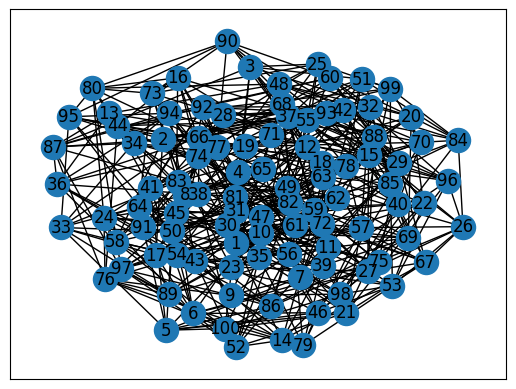

In [28]:
# Physical network
Gp=GeneratePhysicalNetwork()
nx.draw_networkx(Gp)

In [29]:
# Visualize Physical Network in a better way
def VisualizePhysicalNetwork(Gp):
    pos = nx.spring_layout(Gp)
    node_labels = {node: f"{node}\nCPU:{Gp.nodes[node]['CPU']}" for node in Gp.nodes()}
    edge_labels = {(u, v): f"BW:{Gp.edges[u, v]['BW']}" for u, v in Gp.edges()}

    plt.figure(figsize=(12, 12))
    nx.draw(Gp, pos, with_labels=True, labels=node_labels, node_size=700, node_color="lightblue")
    nx.draw_networkx_edge_labels(Gp, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Physical Network")
    plt.show()

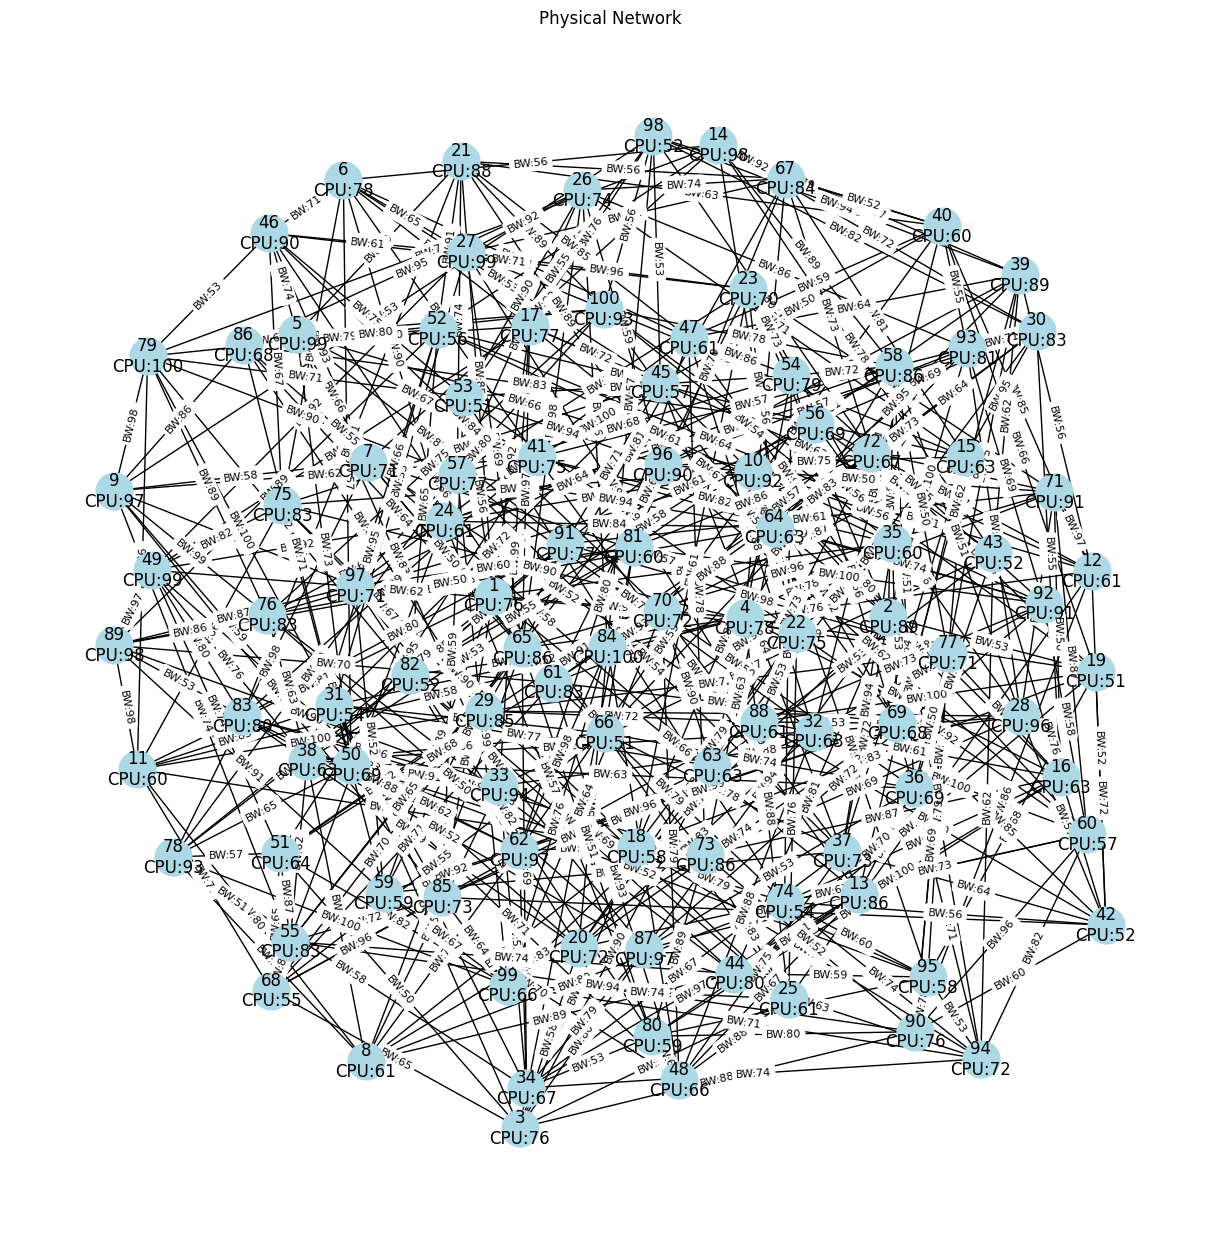

In [30]:
VisualizePhysicalNetwork(Gp)

## MODEL

In [31]:
# Initialize model
model = ConcreteModel()

# Define Sets
nodes = list(Gp.nodes)
links = list(Gp.edges)
contents = ["c1", "c2"]  # Example contents

model.Nodes = Set(initialize=nodes)
model.Links = Set(initialize=links, dimen=2)
model.Contents = Set(initialize=contents)

# Parameters
requests = {n: random.randint(10, 100) for n in nodes}  # Random requests at each node
sources = {(c, n): random.randint(0, 1) for c in contents for n in nodes}  # Random source content locations

model.D = Param(model.Nodes, initialize=requests)
model.S = Param(model.Contents, model.Nodes, initialize=lambda model, c, n: sources.get((c, n), 0))

# Variables
model.x = Var(model.Contents, model.Links, within=NonNegativeIntegers)  # Traffic for content c through link (i,j)
model.y = Var(model.Nodes, within=Binary)  # Whether node is a cache node
model.v = Var(within=NonNegativeReals)  # Maximum traffic

# Objective Function
M = 1e6  # Large constant for prioritizing max traffic minimization
model.Obj = Objective(
    expr=M * model.v + sum(model.x[c, (i, j)] for c in model.Contents for (i, j) in model.Links),
    sense=minimize
)

# Constraints
# Traffic flow constraints (split into two separate constraints)
def traffic_flow_balance_rule_lower(model, c, n):
    R = model.D[n] * (1 - model.S[c, n]) * (1 - model.y[n])
    in_flow = sum(model.x[c, (i, n)] for i, n2 in model.Links if n2 == n)
    out_flow = sum(model.x[c, (n, j)] for n1, j in model.Links if n1 == n)
    return out_flow - in_flow >= R - 1e6 * (model.S[c, n] + model.y[n])

def traffic_flow_balance_rule_upper(model, c, n):
    R = model.D[n] * (1 - model.S[c, n]) * (1 - model.y[n])
    in_flow = sum(model.x[c, (i, n)] for i, n2 in model.Links if n2 == n)
    out_flow = sum(model.x[c, (n, j)] for n1, j in model.Links if n1 == n)
    return out_flow - in_flow <= R

model.TrafficFlowBalanceLower = Constraint(model.Contents, model.Nodes, rule=traffic_flow_balance_rule_lower)
model.TrafficFlowBalanceUpper = Constraint(model.Contents, model.Nodes, rule=traffic_flow_balance_rule_upper)

# Maximum traffic constraint
def max_traffic_rule(model, i, j):
    return model.v >= sum(model.x[c, (i, j)] for c in model.Contents)

model.MaxTraffic = Constraint(model.Links, rule=max_traffic_rule)

# Cache node limit
cache_limit = max(2, int(0.05 * NumNodes))  # Dynamic cache limit based on network size
model.CacheLimit = Constraint(expr=sum(model.y[n] for n in model.Nodes) <= cache_limit)

# Solve the model
solver = SolverFactory('glpk', executable = '/usr/bin/glpsol') # Change to your preferred solver
results = solver.solve(model, tee=True)

# Debugging output
if results.solver.termination_condition != TerminationCondition.optimal:
    print("WARNING: Model could not find an optimal solution.")

# Display results
print("Optimal Cache Nodes:", [n for n in model.Nodes if model.y[n].value == 1])
print("Maximum Traffic:", model.v.value)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpy4osl8y9.glpk.raw --wglp /tmp/tmp54owb9vo.glpk.glp --cpxlp
 /tmp/tmpr_yn985x.pyomo.lp
Reading problem data from '/tmp/tmpr_yn985x.pyomo.lp'...
/tmp/tmpr_yn985x.pyomo.lp:11722: warning: lower bound of variable 'x1004' redefined
/tmp/tmpr_yn985x.pyomo.lp:11722: warning: upper bound of variable 'x1004' redefined
901 rows, 1101 columns, 5906 non-zeros
1100 integer variables, 100 of which are binary
11822 lines were read
Writing problem data to '/tmp/tmp54owb9vo.glpk.glp'...
10814 lines were written
GLPK Integer Optimizer 5.0
901 rows, 1101 columns, 5906 non-zeros
1100 integer variables, 100 of which are binary
Preprocessing...
101 constraint coefficient(s) were reduced
747 rows, 983 columns, 4253 non-zeros
982 integer variables, 96 of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.124e+05  ratio =  1.124e+05
GM: min|aij| =  1.075e-01  max|aij| =  9.304e+00  ratio =  8.657e+01
E

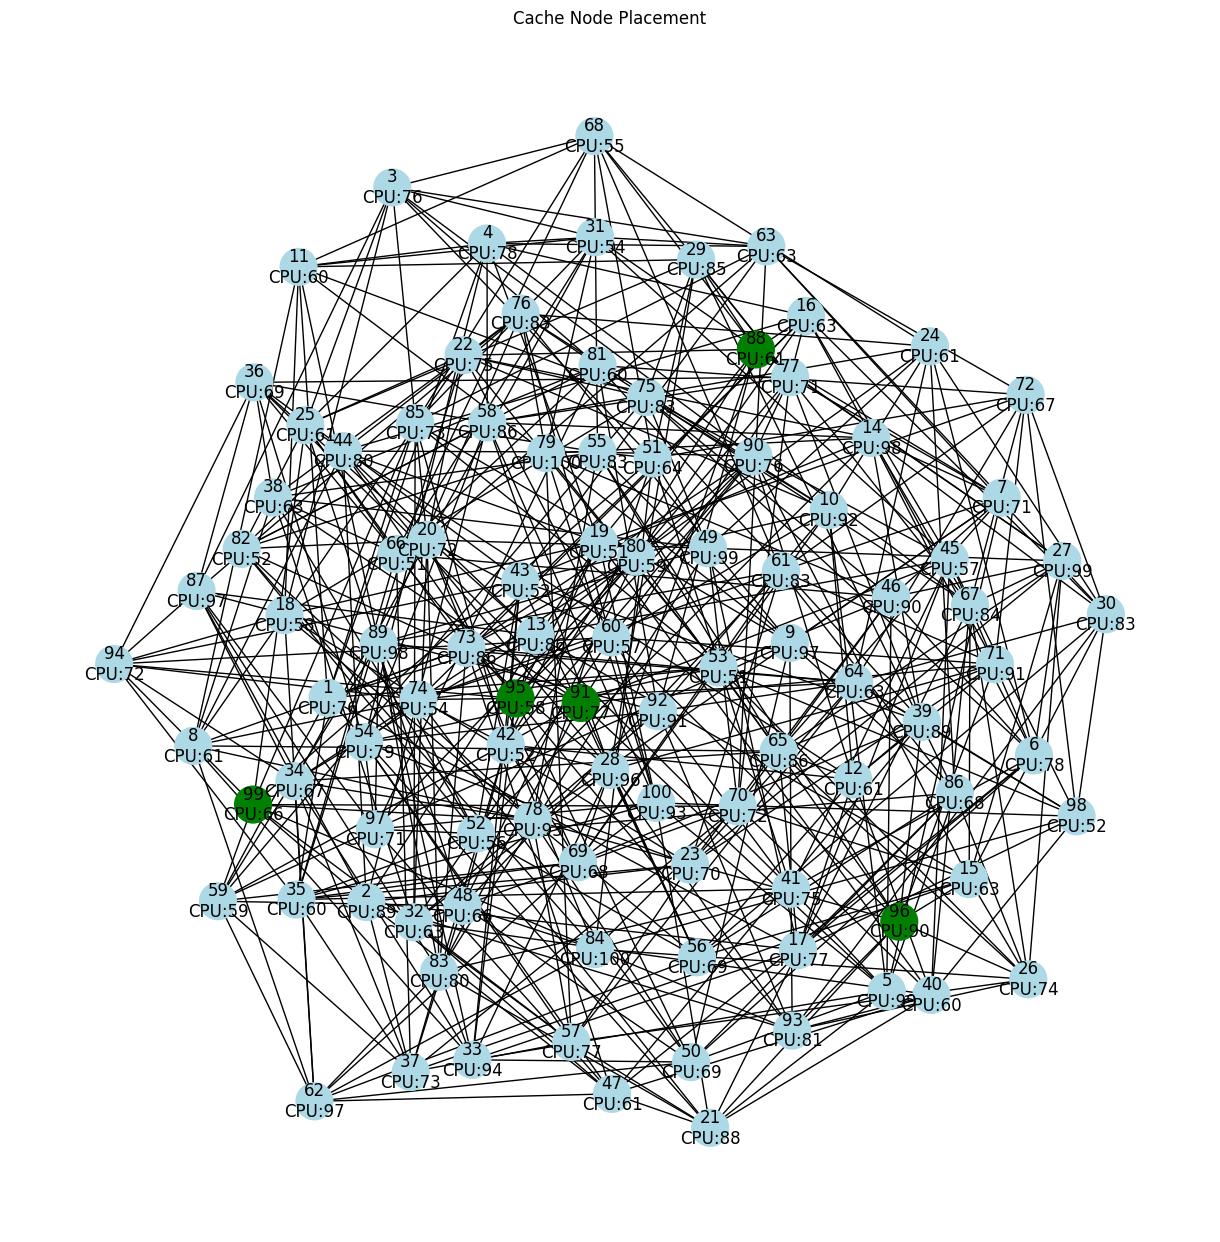

In [32]:
# Visualization of Cache Node Placement
def VisualizeCachePlacement(Gp, cache_nodes):
    pos = nx.spring_layout(Gp)
    node_colors = ["green" if node in cache_nodes else "lightblue" for node in Gp.nodes()]
    node_labels = {node: f"{node}\nCPU:{Gp.nodes[node]['CPU']}" for node in Gp.nodes()}

    plt.figure(figsize=(12, 12))
    nx.draw(Gp, pos, with_labels=True, labels=node_labels, node_size=700, node_color=node_colors)
    plt.title("Cache Node Placement")
    plt.show()

# Visualize results
optimal_cache_nodes = [n for n in model.Nodes if model.y[n].value == 1]
VisualizeCachePlacement(Gp, optimal_cache_nodes)
